In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

In [2]:
from multiprocessing import get_context
import os
# Limit ourselves to single-threaded jax/xla operations to avoid thrashing. See
# https://github.com/google/jax/issues/743.
os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=false "
                           "intra_op_parallelism_threads=4")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from scipy.spatial import distance
from scipy.cluster import hierarchy

import sys, os, itertools
sys.path.append(os.path.abspath("../tools/RENGE/src/renge"))
from renge import Renge

import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

/home/syz/miniconda3/envs/renge_jax/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import anndata as ad
adata_all = ad.read_h5ad(f"hipsc.h5ad")
adata_all.X = adata_all.X.todense()

In [5]:
adata_all.obs.condition = adata_all.obs.ko
adata_all.var.index = adata_all.var.gene

/home/syz/miniconda3/envs/renge_jax/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [6]:
E = pd.DataFrame(adata_all.X, index = adata_all.obs.index, columns=adata_all.var.index)
X = pd.DataFrame(np.zeros_like(adata_all.X), index = adata_all.obs.index, columns = np.array(adata_all.var.index))
for i in range(adata_all.shape[0]):
    if adata_all.obs.condition[i] != "WT":
        X.loc[adata_all.obs.index[i], adata_all.obs.condition[i]] = 1
X["t"] = adata_all.obs["t"]

In [7]:
X.columns[X.sum(0) > 0]

Index(['SOX2', 'POU5F1', 'ZIC3', 'PRDM14', 'RUNX1T1', 'MYC', 'NANOG', 'ZIC2',
       't'],
      dtype='object')

In [8]:
reg = Renge()
A = reg.estimate_hyperparams_and_fit(X, E, n_trials=30)

/home/syz/miniconda3/envs/renge_jax/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/syz/miniconda3/envs/renge_jax/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/syz/miniconda3/envs/renge_jax/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float64', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/syz/miniconda3/envs/renge_jax/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

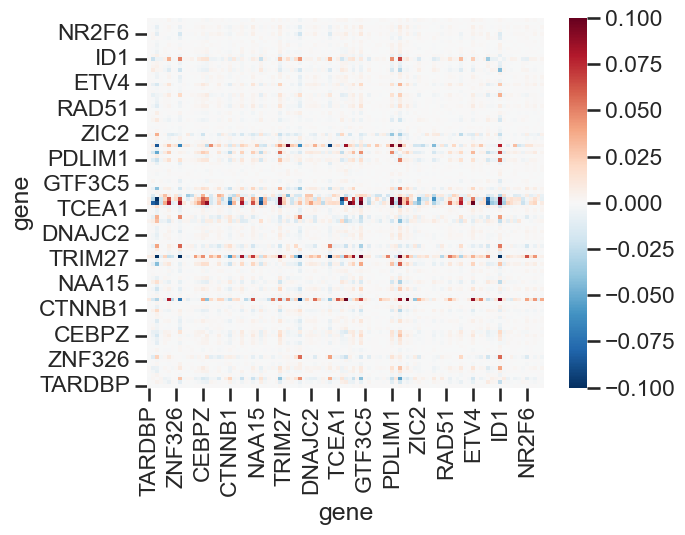

In [15]:
import seaborn as sb
A_pred = pd.DataFrame(A.T, index = adata_all.var.index, columns=adata_all.var.index)
A_pred.to_csv(f"A_renge_output.csv")
sb.heatmap(A_pred, cmap = "RdBu_r", vmin = -0.1, vmax = 0.1)
plt.gca().invert_yaxis()

In [16]:
A_qval = reg.calc_qval(n_boot=30)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [06:06<00:00, 12.23s/it]


In [ ]:
A_filt = A.copy()
A_filt[A_qval >= 0.01] = 0
A_norm = A_filt / np.abs(A_filt).max(axis=0)
A_norm = A_norm.fillna(0)

In [ ]:
A_pred_filter = pd.DataFrame(A_norm.T, index = adata_all.var.index, columns=adata_all.var.index)
A_pred_filter.to_csv(f"A_renge_output_filter.csv")
sb.heatmap(A_pred_filter, cmap = "RdBu_r", vmin = -2.5, vmax = 2.5)
plt.gca().invert_yaxis()